In [8]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.9.0
Tensorflow Probability Version:  0.16.0


In [10]:
import deeplake
ds = deeplake.load("hub://activeloop/celeb-a-train")

hub://activeloop/celeb-a-train loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



In [11]:
dataloader = ds.tensorflow()

Metal device set to: Apple M1


2023-03-07 16:24:56.464202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 16:24:56.464365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
dataloader

TypeError: 'DatasetAdapter' object is not subscriptable

In [9]:
def load_dataset(split):
    train_list_ds = tf.data.Dataset.from_tensor_slices(np.load('./dataset/vae-celeba/{}.npy'.format(split)))
    train_ds = train_list_ds.map(lambda x: (x, x))
    return train_ds

In [10]:
train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

AttributeError: module 'tensorflow' has no attribute 'simulation'

NameError: name 'train_ds' is not defined

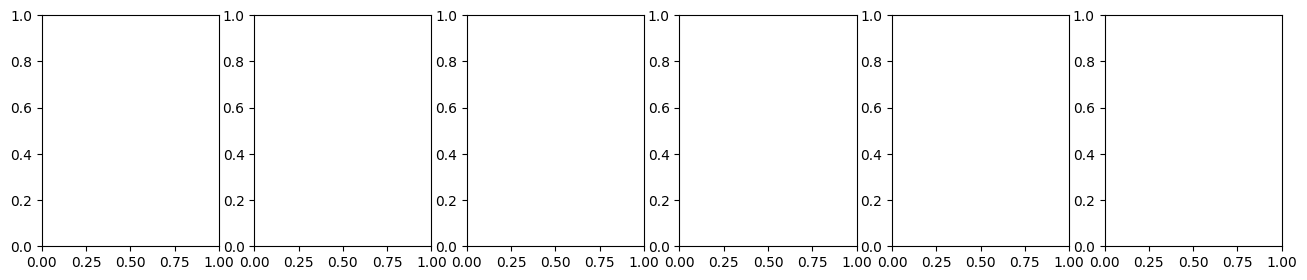

In [11]:
n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [15]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

NameError: name 'train_ds' is not defined

In [16]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [ ]:
prior = get_prior(num_modes=2, latent_dim=50)
prior

In [17]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [18]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

NameError: name 'prior' is not defined

In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape

In [20]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

In [21]:
encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

NameError: name 'kl_regularizer' is not defined

In [22]:
encoder.summary()

NameError: name 'encoder' is not defined

In [23]:
tf.keras.utils.plot_model(encoder)

NameError: name 'encoder' is not defined

In [24]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

In [ ]:
decoder = get_decoder(latent_dim=50)

In [ ]:
decoder.summary()

In [ ]:
tf.keras.utils.plot_model(decoder)

In [ ]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [ ]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
vae.fit(train_ds, validation_data=val_ds, epochs=30)

In [ ]:
test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

In [ ]:
n_reconstructions = 7
num_test_files = np.load('./dataset/vae-celeba/test.npy').shape[0]
test_ds_for_reconstructions = load_dataset('test')
for all_test_images, _ in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

In [ ]:
f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

In [ ]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

In [ ]:
n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();

In [ ]:
def load_labels_and_image_arrays(split):
    dataset = load_dataset(split)
    num_files = np.load('./dataset/vae-celeba/{}.npy'.format(split)).shape[0]
    
    for all_images, _ in dataset.batch(num_files).take(1):
        all_images_np = all_images.numpy()

    labels = pd.read_csv('./dataset/list_attr_celeba_subset.csv')
#     labels = labels[labels['image_id'].isin(files)]
    return labels[:num_files], all_images_np

In [ ]:
train_labels, training_subset = load_labels_and_image_arrays('train')

In [ ]:
train_labels.columns[2:]

In [ ]:
attribute = 'Smiling'
attribute_mask = (train_labels[attribute] == 1)
images_with_attribute = training_subset[attribute_mask]

not_attribute_mask = (train_labels[attribute] == -1)
images_without_attribute = training_subset[not_attribute_mask]

In [13]:
encoded_images_with_attribute = encoder(images_with_attribute)
encoded_images_without_attribute = encoder(images_without_attribute)

NameError: name 'encoder' is not defined

In [14]:
mean_encoded_images_with_attribute = tf.reduce_mean(encoded_images_with_attribute.mean(), 
                                                    axis=0, keepdims=True)
mean_encoded_images_without_attribute = tf.reduce_mean(encoded_images_without_attribute.mean(), 
                                                    axis=0, keepdims=True)

NameError: name 'encoded_images_with_attribute' is not defined

In [15]:
attribute_vector = mean_encoded_images_with_attribute -  mean_encoded_images_without_attribute

NameError: name 'mean_encoded_images_with_attribute' is not defined

In [16]:
decoded_a = decoder(attribute_vector).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

NameError: name 'decoder' is not defined

In [17]:
n_examples = 7
sampled_inx = np.random.choice(images_without_attribute.shape[0], n_examples, replace=False)
sample_images_without_attribute = images_without_attribute[sampled_inx]
sample_images_encodings = encoder(sample_images_without_attribute)
sample_images_reconstructions = decoder(sample_images_encodings).mean()

k = 2.5  # Weighting of attribute vector
modified_sample_images_encodings = sample_images_encodings + (k * attribute_vector)
modified_reconstructions = decoder(modified_sample_images_encodings).mean()

NameError: name 'images_without_attribute' is not defined

NameError: name 'sample_images_without_attribute' is not defined

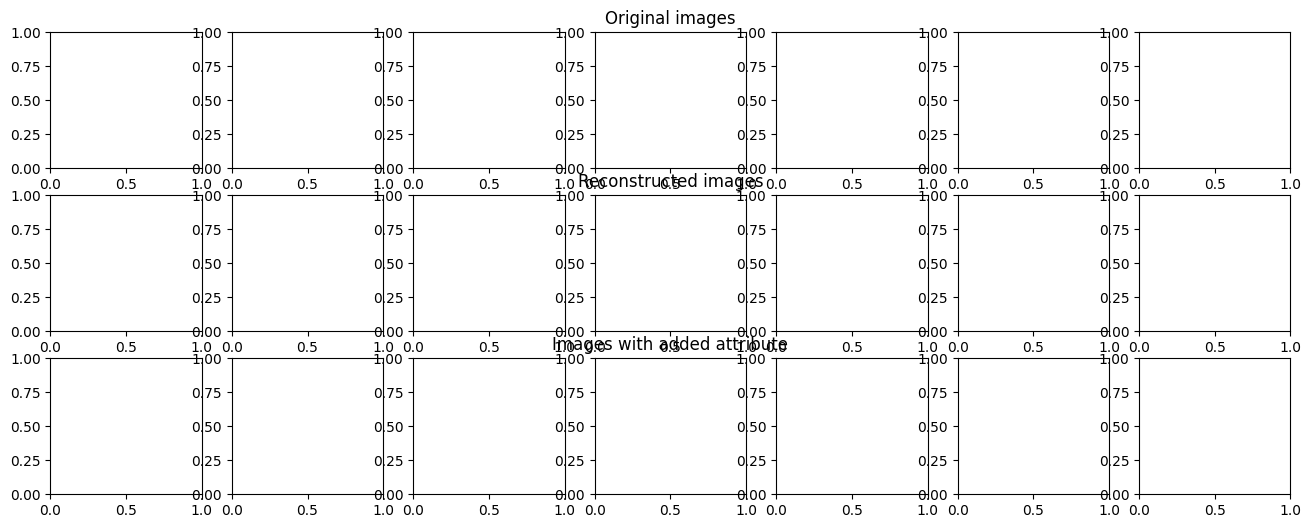

In [18]:
f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")
for j in range(n_examples):
    axs[0, j].imshow(sample_images_without_attribute[j])
    axs[1, j].imshow(sample_images_reconstructions[j])
    axs[2, j].imshow(modified_reconstructions[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();